# Car-mpg

In [111]:
include("RealWorldData.ji")
using Plots

## Carmpg dataset

In [234]:
X, Z, y, zmap = get_cardata()
y = y ./(maximum(y) - minimum(y)) 
y = y .- mean(y)
zmap

1-element Vector{Any}:
 Dict{Any, Any}(2 => [0, 0], 3 => [0, 1], 1 => [1, 0])

## PLSIQR fitting

In [246]:
ntrain = 260
ntest = 392 - ntrain
indr, indt = get_train_index(Z, ntrain)

Xr, Zr, yr = X[indr, :], Z[indr, :], y[indr]
Xt, Zt, yt = X[indt, :], Z[indt, :], y[indt]
width_exp1 = -0.2
width_exp5 = -0.2
width_exp9 = -0.2

# car_model9 = qgplsim.model(Xr, Zr, yr, [0.75], width_exp9)
# car_model1 = qgplsim.model(Xr, Zr, yr, [0.25], width_exp1)
car_model5 = qgplsim.model(Xr, Zr, yr, [0.5], width_exp5)
# qgplsim.estimator(car_model9)
# qgplsim.estimator(car_model1)
qgplsim.estimator(car_model5)

# qgplsim.print_model(car_model1)
# qgplsim.print_model(car_model5)
# qgplsim.print_model(car_model9)

carmodel = car_model5
vv = Xt * carmodel.theta + Zt * carmodel.gamma
ylx = Xt * carmodel.alpha
ylz = Zt * carmodel.beta
gv = qgplsim.predict(carmodel, Xt, Zt)
yp = gv + ylx + ylz

qgplsim.print_model(carmodel)

alpha => [-0.0052, -0.0205, 0.0331, -0.0151]
theta => [0.8559, -0.2085, 0.2013, 0.4283]
gamma => [0.1194, 0.0119]
beta => [0.0744, 0.0705]


In [247]:
rmsd(yp, yt)

0.0947378946728352

## 单次实验，测试集预测的结果与真实值的对比

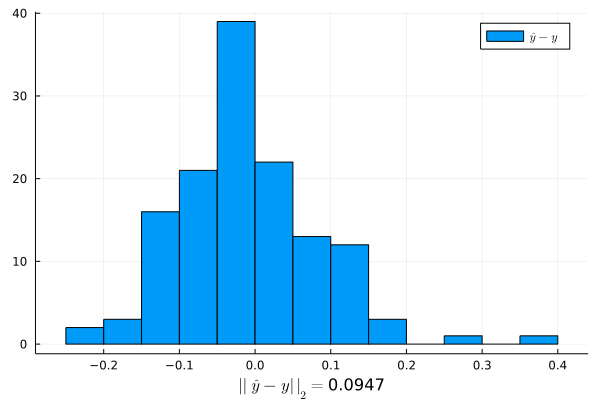

In [248]:
using LaTeXStrings
e = round(rmsd(yp, yt), digits = 4)
str = string(L"||\hat{y} - y||_2 = ", "$e")
histogram(yt .- yp, label = L"\hat{y} - y")
xlabel!(str)

## 分类变量$z_i$, $i = 1,2,3$， 非参部分估计的在$q = 0.5$时的拟合曲线

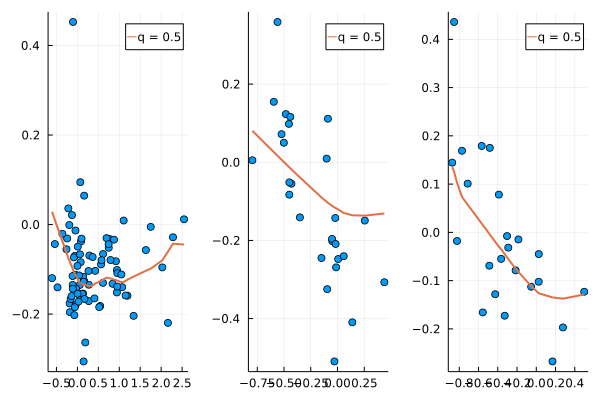

In [121]:
fig = plot(layouts = (1,3))
categ, index = collection(Zt)
for k in 1:3
    pk = fig.subplots[k]
    zk = categ[k]
    indk = index[zk]
    
    vk = vv[indk]   
    ypk = gv[indk]   
    ytk = yt[indk] - ylx[indk] - ylz[indk]

    sort_ind = sortperm(vk)

    scatter!(pk, vk, ytk, label = false)
    plot!(pk, vk[sort_ind], ypk[sort_ind], width = 2, label = "q = 0.5")

end
fig

## Monte Carlo: compared with a semi-mave method from Xia. (2006) 

In [210]:
include("./src/semi_mave.ji")

n_repeat = 25
rec_rmsd_qr = []
rec_rmsd_mave = []
Alpha = []
Theta = []
Beta = []
Gamma = []
width_exp = -0.2
@threads for t in 1:4
    for k in 1:n_repeat
    indr, indt = get_train_index(Z, ntrain)

    Xr, Zr, yr = X[indr, :], Z[indr, :], y[indr]
    Xt, Zt, yt = X[indt, :], Z[indt, :], y[indt]


    car_model = qgplsim.model(Xr, Zr, yr, [0.5], width_exp)
    qgplsim.estimator(car_model)
    push!(Alpha, car_model.alpha)
    push!(Beta, car_model.beta)
    push!(Theta, car_model.theta)
    push!(Gamma, car_model.gamma)

    vv = Xt * carmodel.theta + Zt * carmodel.gamma
    ylx = Xt * carmodel.alpha
    ylz = Zt * carmodel.beta
    gv = qgplsim.predict(carmodel, Xt, Zt)
    yp = gv + ylx + ylz  
        
    car_model_mr = semiMAVE.model(Xr, Zr, yr)
    semiMAVE.estimator(car_model_mr)   
    gvm, = semiMAVE.predictor(car_model_mr, Xt, Zt)
    yp_mave = gvm  + Zt * car_model_mr.β


    push!(rec_rmsd_qr, rmsd(yp, yt))
    push!(rec_rmsd_mave, rmsd(yp_mave, yt))

    end
end

┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitq

## 100次蒙特卡洛模拟后各个参数的均值

In [255]:
[[:alpha, :theta] [mean(Alpha) mean(Theta)]']

2×5 Matrix{Any}:
 :alpha  -0.0468755  -0.0340547  -0.01587    -0.0929639
 :theta   0.768657   -0.260028    0.0183787   0.113651

In [258]:
[[:beta, :gamma] [mean(Beta) mean(Gamma)]']

2×3 Matrix{Any}:
 :beta   0.152955    0.0549003
 :gamma  0.0323051  -0.0091581

从估计可以看到，

$|\alpha| << |\theta|$, 说明连续变量基本没有线性的影响

$\beta_1 \approx 0.15, \beta_2 \approx 0.05, \gamma_1 \approx 0.03, \gamma_2 \approx 0$，

说明本数据集中分类变量会同时影响线性和非参部分的估计

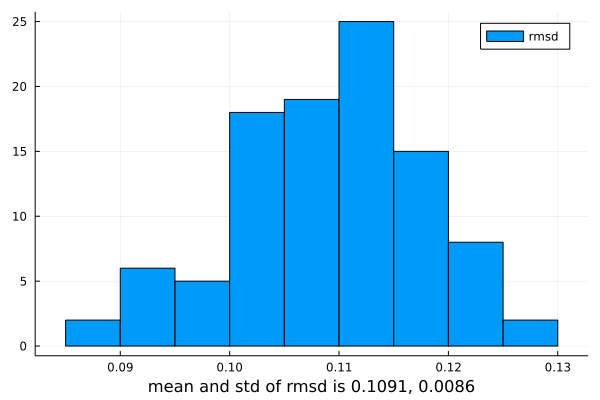

In [223]:
histogram(rec_rmsd_qr, label = "rmsd")
mrmsd = round(mean(rec_rmsd_qr), digits = 4)
std_rmsd = round(std(rec_rmsd_qr), digits = 4)
xlabel!("mean and std of rmsd is $mrmsd, $std_rmsd")

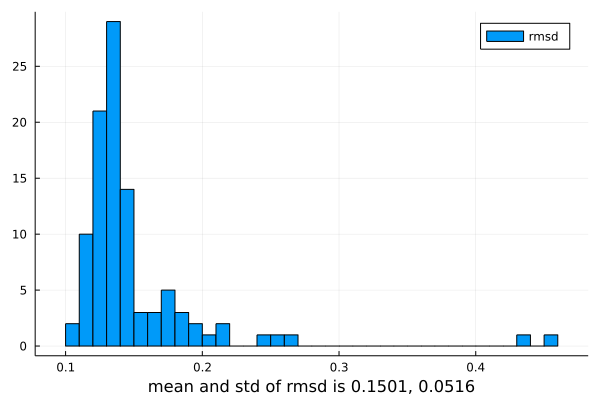

In [224]:
histogram(rec_rmsd_mave[rec_rmsd_mave .< 0.5], label = "rmsd")
mrmsd_mave = round(mean(rec_rmsd_mave), digits = 4)
std_rmsd_mave = round(std(rec_rmsd_mave), digits = 4)

xlabel!("mean and std of rmsd is $mrmsd_mave, $std_rmsd_mave")

## 总结

在这个数据集的实验中，夏老师的方法的精度对窗宽的更敏感，而且经常会出现实验误差很大的情况，如上图；

PLSIQR方法则对窗宽敏感度低，多次蒙特卡洛实验均未出现误差离群的情况；

单纯就这个数据集来说精度上也比夏老师的方法好很多。

#  California Housing

In [225]:
include("./src/supportFunctions.ji")
include("./src/qgplsim.ji")
# include("./src/semi_mave.ji")
include("RealWorldData.ji")
using Plots


In [226]:

Xa, Za, ya = califdata(4.035) # a for all
Z, zmap = categ_binary(Za) # [:, 1]
zmap

2-element Vector{Any}:
 Dict{Any, Any}(2 => [0], 1 => [1])
 Dict{Any, Any}("NEAR BAY" => [1, 0, 0], "INLAND" => [0, 0, 1], "NEAR OCEAN" => [0, 0, 0], "<1H OCEAN" => [0, 1, 0])

## One Single Simulation

In [227]:
Xa, Za, ya = califdata(4.035) # a for all
n = length(ya)

X = scaler(Xa, 1)
y = ya ./(maximum(ya) - minimum(ya)) 
y = y .- mean(y)
Z, zmap = categ_binary(Za) # [:, 1]

ntrain = 2000
ntest = 1000
indr, indt = get_train_index(Z, ntrain)

indt = indt[shuffle(1:(n - ntrain))[1:ntest]]
ntest = length(indt)
Xr = X[indr, :]
yr = y[indr] 
Zr = Z[indr, :]

Xt = X[indt, :]
yt = y[indt]  
Zt = Z[indt, :]
sum(Zr, dims = 1)

1×4 Matrix{Float64}:
 841.0  224.0  890.0  629.0

In [228]:
# include("./src/qgplsim.ji")
width_exp = -0.2
dy = 0
method = "qr"
qsmodel = qgplsim.model(Xr, Zr, yr, [0.5], width_exp)
qsmodel1 = qgplsim.model(Xr, Zr, yr, [0.1], width_exp)
qsmodel9 = qgplsim.model(Xr, Zr, yr, [0.9], width_exp)


@time qgplsim.estimator(qsmodel)
# @time qgplsim.estimator(qsmodel1)
# @time qgplsim.estimator(qsmodel9)

vv = Xt * qsmodel.theta
ylx = Xt * qsmodel.alpha
ylz = Zt * qsmodel.beta
gv = qgplsim.predict(qsmodel, Xt, Zt, dy, method)
yp = gv + ylx  + ylz

# vv1 = Xt * qsmodel1.theta
# ylx1 = Xt * qsmodel1.alpha
# ylz1 = Zt * qsmodel1.beta
# gv1 = qgplsim.predict(qsmodel1, Xt, Zt, dy, method)
# yp1 = gv1 + ylx1  + ylz1

# vv9 = Xt * qsmodel9.theta
# ylx9 = Xt * qsmodel9.alpha
# ylz9 = Zt * qsmodel9.beta
# gv9 = qgplsim.predict(qsmodel9, Xt, Zt, dy, method)
# yp9 = gv9 + ylx9  + ylz9


qgplsim.print_model(qsmodel)

┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69


  8.959008 seconds (36.40 M allocations: 3.414 GiB, 11.62% gc time, 5.10% compilation time)
  7.211304 seconds (34.83 M allocations: 3.320 GiB, 4.62% gc time)
  7.168034 seconds (34.83 M allocations: 3.322 GiB, 4.60% gc time)
alpha => [0.0335, 0.0202, 0.0332]
theta => [0.3652, 0.5849, -0.7243]
gamma => [-0.0451, -0.2024, 0.1653, 0.3068]
beta => [0.0135, -0.043, -0.0005, -0.1458]


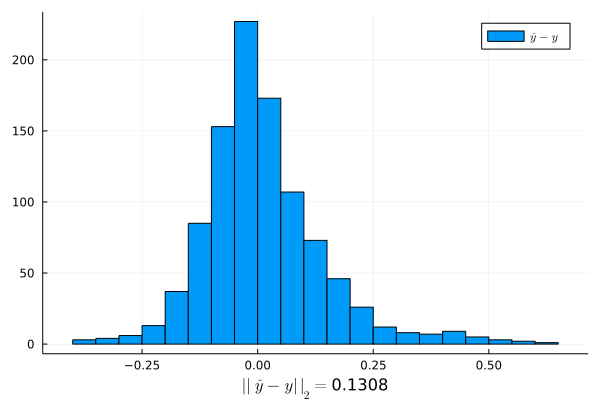

In [229]:
using LaTeXStrings
e = round(rmsd(yp, yt), digits = 4)
str = string(L"||\hat{y} - y||_2 = ", "$e")
histogram(yt .- yp, label = L"\hat{y} - y")
xlabel!(str)

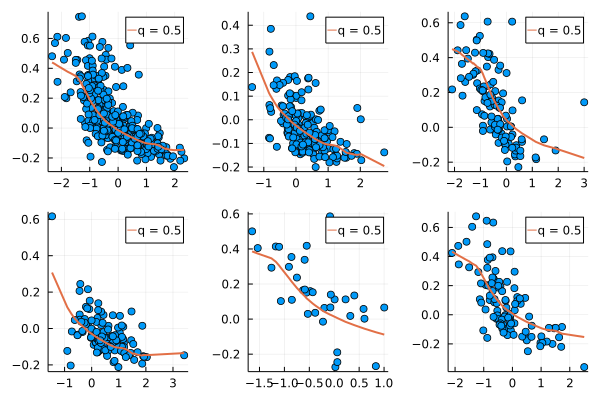

In [231]:
fig = plot(layouts = (2,3))
categ, index = collection(Zt)
for k in 1:6
    pk = fig.subplots[k]
    zk = categ[k]
    indk = index[zk]
    
    vk = vv[indk]
    vk1 = vv1[indk]
    vk9 = vv9[indk]
    
    ypk = gv[indk]
    yp1k = gv1[indk]
    yp9k = gv9[indk]
    
    ytk = yt[indk] - ylx[indk] - ylz[indk]
    ytk1 = yt[indk] - ylx1[indk] - ylz1[indk]
    ytk9 = yt[indk] - ylx9[indk] - ylz9[indk]

    sort_ind = sortperm(vk)
    sort_ind1 = sortperm(vk1)
    sort_ind9 = sortperm(vk9)

    scatter!(pk, vk, ytk, label = false)
    plot!(pk, vk[sort_ind], ypk[sort_ind], width = 2, label = "q = 0.5")
    # plot!(pk, vk1[sort_ind1], yp1k[sort_ind1], width = 2, label = "q = 0.1")
    # plot!(pk, -vk9[sort_ind9], yp9k[sort_ind9], width = 2, label = "q = 0.9")

end
fig

In [232]:
include("./src/semi_mave.ji")
car_model_mr = semiMAVE.model(Xr, Zr, yr)
@time semiMAVE.estimator(car_model_mr) 
semiMAVE.print_model(car_model_mr)

 44.086514 seconds (1.56 G allocations: 60.517 GiB, 14.82% gc time, 0.24% compilation time)
theta => [-0.1465, -0.7432, 2.0316]
beta => [-0.0458, -0.1322, -0.2005, -0.3399]


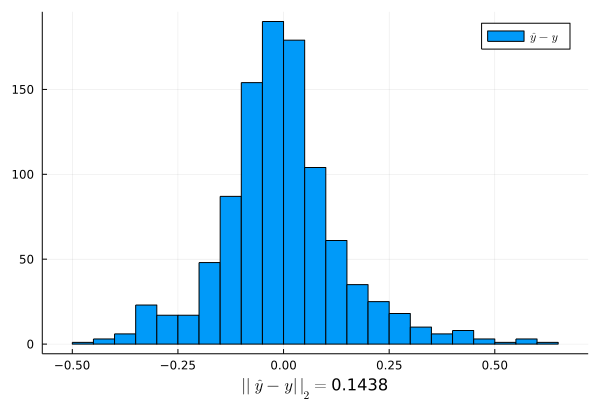

In [233]:
gvm, = semiMAVE.predictor(car_model_mr, Xt, Zt)
ypm = gvm + Zt * car_model_mr.β
em = round(rmsd(ypm, yt), digits = 4)
str = string(L"||\hat{y} - y||_2 = ", "$em")
histogram(yt .- ypm, label = L"\hat{y} - y")
xlabel!(str)

## 总结


这个数据集样本量太大而且没有发现精度优势，不过我们的方法因为无迭代，所以在大样本问题上计算时间上快很多（5倍左右）;

很难找到该方法非常适应的数据集，很多情况下和夏老师的方法精度都类似；

似乎我们的方法有更快的速度和更好的鲁棒性？